In [1]:
from __future__ import division

import os
import pandas as pd                     # library to handle data even from spreadsheets 
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib import rc, rcParams
import scipy.integrate as integrate
from scipy import interpolate
from scipy.interpolate import griddata  # useful for not-regular grid points
import pylab
import time
import scipy.special as bessel
import sys
import scipy.optimize as opt
from scipy.optimize import curve_fit
import matplotlib.ticker as mticker
import itertools

In [2]:
###############
# LaTeX block #
###############

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})
rc('xtick', labelsize=18)
rc('ytick', labelsize=18)
rcParams['legend.numpoints'] = 1

In [3]:
########################################################
# CONSTANTS: physical constants and conversion factors #
########################################################


pi = math.pi                    # pi-greek
m_p = .939                      # proton mass in GeV/c^2
m_e = 0.000510998918            # electron mass in GeV/c^2
c = 2.99*pow(10,10)             # speed of light in [cm sec^(-1)]
b_0 = 1.4*pow(10,-16)           # energy loss coefficient (due to IC scattering and synchrotron) in [GeV^(-1) s^(-1)]


c2kB = 6.50966198               # divided by 10^36
pc_mt = 3.0857e+16              # parsec in meters
pc_cm = 3.0857e+18              # parsec in centimeters
m_to_pc = pow(pc_mt,-1)         # to pass from meters to parsec
cm_to_pc = 3.24 * pow(10,-19)   # to pass from centimeters to parsec
conv_factor_GeV_to_erg = 0.00160218   # the value in [GeV] has to be multipled by this factor
conv_factor_erg_to_GeV = 624.151
conv_factor_yr_to_sec = 31.56*pow(10,6)
conv_GeV_g = 1.78e-24

# <center> Plasma parameters

$$
\begin{aligned}
&x_c \equiv \left( \frac{6 \rho M_A^2 L_{\mathrm{inj}} v_A}{\eta_0} \right)^{2/3} \\
&\rho = n_{\mathrm{ISM}} \cdot m_p, \qquad \eta_0 = 6 \cdot 10^{3} \, \left( \frac{37}{\mathrm{ln} \, \Lambda} \right) \left( \frac{T_{\mathrm{ISM}}}{10^8 \, \mathrm{K}} \right)^{5/2} \frac{\mathrm{g}}{\mathrm{cm \cdot s}} \; \left( \mathrm{Spitzer} \, 1962 \right), \qquad \mathrm{ln} \, \Lambda \equiv \mathrm{ln} \, \left( \frac{b_{\mathrm{max}}}{b_{\mathrm{min}}} \right) \simeq \mathrm{ln} \, \left( \frac{\lambda_D}{b_{\mathrm{min}}} \right), \, b_{\mathrm{min}} \approx 8.63 \cdot 10^{-8} \left( \frac{10^4 \, \mathrm{K}}{T_{\mathrm{ISM}}} \right) \, \mathrm{cm} \\
& \lambda_D \approx 0.95 \cdot 10^5 \cdot \left( \frac{T}{10^6 \, \mathrm{K}} \right)^{1/2} \left( \frac{10^{-3} \, \mathrm{cm}^{-3}}{n_{\mathrm{ISM}}} \right)^{1/2} \, \mathrm{cm} \\
&\beta = 3.3 \cdot \left( \frac{3 \, \mu\mathrm{G}}{B_{\mathrm{Cyg}}} \right)^2 \left( \frac{n_{\mathrm{ISM}}}{1 \, \mathrm{cm^{-3}}} \right) \left( \frac{T_{\mathrm{ISM}}}{10^4 \, \mathrm{K}} \right) \\
& v_A = 6.27 \cdot 10^5 \, \left( \frac{B_{\mathrm{Cyg}}}{3 \, \mu\mathrm{G}} \right) \left( \frac{1 \, \mathrm{cm^{-3}}}{n_{\mathrm{ISM}}} \right)^{1/2} \, \mathrm{cm \cdot s^{-1}}
\end{aligned}
$$

In [4]:
################################
### Environmental parameters ###
################################

gamma_ratio = m_p/m_e


B_field = 6.         # magnetic field, in [muGauss]
n_ISM = 1.e-3        # density of the environment, in [cm^{-3}]
T_ISM = 2.e6         # in [K]

L_halo = 100.             # in [pc]
M_A_halo = 1.             # Alfvénic Mach Number


###
v_A = 6.27e5 * (B_field / 3.) * (1. / n_ISM)**(1/2)
rho = n_ISM * (m_p * conv_GeV_g)
Debye_length = 0.95e5 * (T_ISM / 1.e6)**(1/2) * (1.e-3 / n_ISM)**(1/2)    # in [cm]

b_min = 8.63e-8 * (1.e4 / T_ISM)                                          # in [cm]
ln_Lambda = np.log(Debye_length / b_min)
eta_0 = 6.e3 * (37 / ln_Lambda) * (T_ISM / 1.e8)**(5/2)  # in [g cm^{-1} s^{-1}]


x_c = ( (6 * rho * M_A_halo**2 * (L_halo*pc_cm) * v_A) / (eta_0) )**(2/3)
beta_halo = 3.3 * (3. / B_field)**2 * (n_ISM / 1.) * (T_ISM / 1.e4)
###


print('rho =', rho, '[g]')
print('')
print('v_A =', v_A / 1.e5, '[km s^{-1}]')
print('')
print('ln_Lambda =', ln_Lambda)
print('')
print('x_c =', x_c)
print('')
print('plasma beta =', beta_halo)

rho = 1.67142e-27 [g]

v_A = 396.5496185851148 [km s^{-1}]

ln_Lambda = 33.37195936626772

x_c = 47.37630831065164

plasma beta = 0.165


# <center>Truncation Scale
    
### Collisionless damping

$$\begin{align}
&k_{\mathrm{max}} L_{\mathrm{inj}} = \frac{4 \, M_A^4 \, \gamma \, \xi^2}{\pi \, \beta \, (1 - \xi^2)^2} e^{\frac{2}{\beta \, \gamma \, \xi^2}}\\[10pt]
&\gamma = \frac{m_p}{m_e}\\[10pt]
&\beta = \frac{P_g}{P_B}
\end{align}$$

### Collisional damping (viscous)

$$\begin{align}
&k_{\mathrm{max}} L_{\mathrm{inj}} = \begin{cases}
    x_c \, (1 - \xi^2)^{-2/3} & \beta \ll 1\\
    x_c \, (1 - 3 \, \xi^2)^{-4/3} & \beta \gg 1
  \end{cases}\\[10pt]
&x_c =  \left( \frac{6 \, \rho \, \delta V^2 \, L_{\mathrm{inj}}}{\eta_0 \, v_A} \right)^{2/3} = \left( \frac{6 \, \rho \, M_A^2 \, L_{\mathrm{inj}} \, v_A}{\eta_0} \right)^{2/3}
\end{align}$$

In [5]:
path_updated_plots = '/Users/ottaviofornieri/PHYSICS_projects/Diffusion_Fast_Modes/Plots_GSSI/'

/var/folders/7v/3qsg7nrd5fx6_1r1kwx67hlm0000gn/T/ipykernel_42715/3676798875.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  kmax_L_arr_collisionless[i] = ( 4 * pow(M_A_halo,4) * gamma_ratio * pow(np.cos(np.radians(theta[i])),2) ) / ( pi * beta_halo * ( pow(np.sin(np.radians(theta[i])),4) ) ) * np.exp(2 / ( beta_halo * gamma_ratio * pow(np.cos(np.radians(theta[i])),2) ) )
/var/folders/7v/3qsg7nrd5fx6_1r1kwx67hlm0000gn/T/ipykernel_42715/3676798875.py:12: RuntimeWarning: overflow encountered in exp
  kmax_L_arr_collisionless[i] = ( 4 * pow(M_A_halo,4) * gamma_ratio * pow(np.cos(np.radians(theta[i])),2) ) / ( pi * beta_halo * ( pow(np.sin(np.radians(theta[i])),4) ) ) * np.exp(2 / ( beta_halo * gamma_ratio * pow(np.cos(np.radians(theta[i])),2) ) )
/var/folders/7v/3qsg7nrd5fx6_1r1kwx67hlm0000gn/T/ipykernel_42715/3676798875.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  kmax_L_arr_viscous[i] = x_c * pow( 1 - pow(np.cos(np.radians(theta[i])),2) , -2

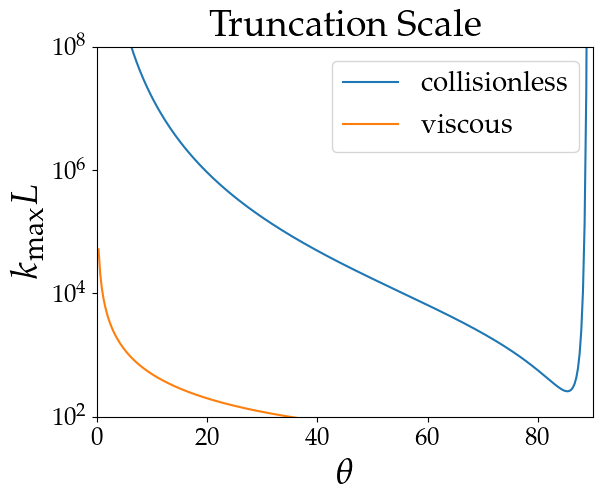

In [6]:
##################################################
### Calculate the truncation scale for damping ###
##################################################

theta = np.linspace(0., 90., num=300)    # wave pitch-angle in degrees

# collisionless
def kmax_L_func_coll(theta_arr):
    kmax_L_arr_collisionless = np.zeros(len(theta_arr))
    #'''
    for i in range(len(theta_arr)):
        kmax_L_arr_collisionless[i] = ( 4 * pow(M_A_halo,4) * gamma_ratio * pow(np.cos(np.radians(theta[i])),2) ) / ( pi * beta_halo * ( pow(np.sin(np.radians(theta[i])),4) ) ) * np.exp(2 / ( beta_halo * gamma_ratio * pow(np.cos(np.radians(theta[i])),2) ) )
        #'''
    
    #kmax_L_arr_collisionless.fill(1.e+15)
    return kmax_L_arr_collisionless

# collisional (viscous)
def kmax_L_func_visc(theta_arr):
    kmax_L_arr_viscous = np.zeros(len(theta_arr))
    #'''
    for i in range(len(theta_arr)):
        kmax_L_arr_viscous[i] = x_c * pow( 1 - pow(np.cos(np.radians(theta[i])),2) , -2/3)
        #'''
    
    #kmax_L_arr_viscous.fill(1.e+15)
    return kmax_L_arr_viscous
    
        
kmax_L_H, = plt.plot(theta, kmax_L_func_coll(theta))
kmax_L_d, = plt.plot(theta, kmax_L_func_visc(theta))

plt.legend([kmax_L_H, kmax_L_d],[
    r'collisionless',
    r'viscous',
    ],loc='best', fontsize=20)

plt.title("Truncation Scale", fontsize=27, loc='center', pad=None)

plt.axis([0.,90., 1.e2,1.e8])
plt.xlabel('$\\theta$',fontsize=27)
plt.ylabel('$k_{\mathrm{max}}L$',fontsize=27)
plt.yscale('log')

plt.savefig(path_updated_plots + 'Truncation_scales.pdf',format='pdf',bbox_inches='tight', dpi=200)

/var/folders/7v/3qsg7nrd5fx6_1r1kwx67hlm0000gn/T/ipykernel_42715/3676798875.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  kmax_L_arr_collisionless[i] = ( 4 * pow(M_A_halo,4) * gamma_ratio * pow(np.cos(np.radians(theta[i])),2) ) / ( pi * beta_halo * ( pow(np.sin(np.radians(theta[i])),4) ) ) * np.exp(2 / ( beta_halo * gamma_ratio * pow(np.cos(np.radians(theta[i])),2) ) )
/var/folders/7v/3qsg7nrd5fx6_1r1kwx67hlm0000gn/T/ipykernel_42715/3676798875.py:12: RuntimeWarning: overflow encountered in exp
  kmax_L_arr_collisionless[i] = ( 4 * pow(M_A_halo,4) * gamma_ratio * pow(np.cos(np.radians(theta[i])),2) ) / ( pi * beta_halo * ( pow(np.sin(np.radians(theta[i])),4) ) ) * np.exp(2 / ( beta_halo * gamma_ratio * pow(np.cos(np.radians(theta[i])),2) ) )
/var/folders/7v/3qsg7nrd5fx6_1r1kwx67hlm0000gn/T/ipykernel_42715/3676798875.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  kmax_L_arr_viscous[i] = x_c * pow( 1 - pow(np.cos(np.radians(theta[i])),2) , -2

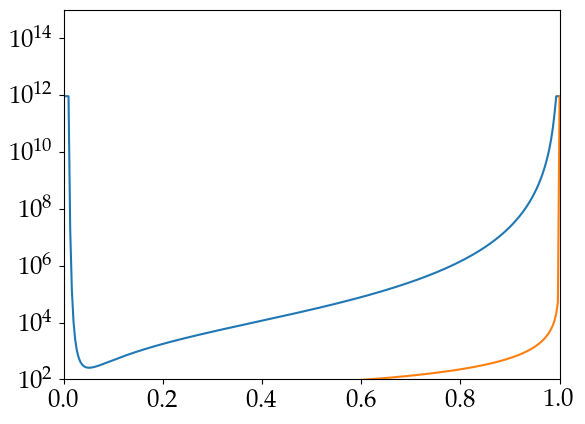

In [7]:
# dissipation-scale of the turbulence
r_L_minE = 3.37 * pow(10,10)  # in [cm], for 10^{-2} GeV particles
r_L_inverse_minE_2ordersMore = ( 1 / (r_L_minE) ) * pow(10,2)  # max k

kmax_L_coll_array = np.zeros( len(theta)  )
kmax_L_coll_minscale = np.zeros( len(theta)  )
kmax_L_visc_array = np.zeros( len(theta)  )
kmax_L_visc_minscale = np.zeros( len(theta)  )

kmax_L_reversed_coll = np.zeros( len(theta)  )
kmax_L_reversed_visc = np.zeros( len(theta)  )


kmax_L_coll_array = kmax_L_func_coll(theta)
for j in range(len(theta)):
    kmax_L_coll_minscale[j] = min(kmax_L_coll_array[j], r_L_inverse_minE_2ordersMore * (L_halo*pc_cm))
kmax_L_reversed_coll = kmax_L_coll_minscale[::-1]

kmax_L_visc_array = kmax_L_func_visc(theta)
for i in range(len(theta)):
    kmax_L_visc_minscale[i] = min(kmax_L_visc_array[i], r_L_inverse_minE_2ordersMore * (L_halo*pc_cm))

kmax_L_reversed_visc = kmax_L_visc_minscale[::-1]

csi = np.linspace(0., 1., num=len(theta))

plt.plot(csi, kmax_L_reversed_coll)   # just to check it's correct
plt.plot(csi, kmax_L_reversed_visc)
plt.axis([0.,1., 1.e2,1.e15])
plt.yscale('log')

# <center>Diffusion Coefficient

### $D_{\mu \mu}$ for fast-modes TTD

$$\begin{align}
&D^{T}_{\mu \mu} \, \frac{L}{v} = \frac{M_A^2 \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{2 R^2 M^{1/2}_A} \, \int^1_0 d \xi \int^{k_{max}L(\xi)}_1 dx \, \xi \, J_1^2(\omega) \, x^{-5/2} e^{-\frac{ \left(\mu \, - \, \frac{v_A}{c \, \xi}\right)^2 }{(1 - \mu^2) M_A} } \\[10pt]
&\omega = R \, x \, (1 - \xi^2)^{1/2} (1 - \mu^2)^{1/2} \\[10pt]
&R = \frac{r_L}{L}
\end{align}$$

### $D_{\mu \mu}$ for fast-modes Gyroresonance

$$D^{G}_{\mu \mu} \, \frac{L}{v} = \frac{M_A^2 \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{2 R^2 M^{1/2}_A} \, \int^1_0 d \xi \int^{k_{max}L(\xi)}_1 dx \, \xi \, \sum^{+\infty}_{n=-\infty} J_n^{'2}(\omega) \, x^{-5/2} e^{-\frac{ \left(\mu \, - \, \frac{n}{x \, R \, \xi}\right)^2 }{(1 - \mu^2) M_A} }$$

$$(D^{G, n=+1}_{\mu \mu} + D^{G, n=-1}_{\mu \mu}) \cdot \frac{L}{v} = \frac{M_A^{3/2} \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{2 R^2} \, \int^1_0 d \xi \int^{k_{max}L(\xi)}_1 dx \, \xi \, \left( \frac{J_0(\omega) - J_2(\omega)}{2} \right)^2 \, x^{-5/2} \left( e^{-\frac{ \left(\mu \, + \, \frac{n}{x \, R \, \xi}\right)^2 }{(1 - \mu^2) M_A} } + e^{-\frac{ \left(\mu \, - \, \frac{n}{x \, R \, \xi}\right)^2 }{(1 - \mu^2) M_A} } \right) $$

### $D_{\mu \mu}$ for Alfvén modes
### $(M_A \leq 1)$

$$ D^A_{\mu \mu} = \frac{2 v M^{4/3}_A \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{3 L R^2 M_A^{1/2}} \, \int d x_{\parallel} \int d x_{\perp} \sum_{n=-\infty}^{+\infty} \frac{n^2 \, J^2_{n}(\omega)}{\omega^2} \cdot \frac{x_{\perp}^{-7/3}}{x_{\parallel}} \cdot e^{-\left( \frac{x_{\parallel}}{M_A^{4/3} x_{\perp}^{2/3}} + \frac{ \left( \mu \, + \, \frac{n}{x_{\parallel} R} \right)^2}{M_A \, (1 - \mu^2)}  \right)}$$

$$\begin{align}
&\left( D^{A, \, n=+1}_{\mu \mu} + D^{A, \, n=-1}_{\mu \mu} \right) \cdot \frac{L}{v} = \frac{2 M_A^{5/6} \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{3 R^2} \, \int d x_{\parallel} \int d x_{\perp} \frac{J^2_{1}(\omega)}{\omega^2} \cdot \frac{x_{\perp}^{-7/3}}{x_{\parallel}} \cdot e^{- \frac{x_{\parallel}}{M_A^{4/3} x_{\perp}^{2/3}} } \left( e^{-\frac{ \left(\mu \, + \, \frac{n}{x_{\parallel} \, R}\right)^2 }{(1 - \mu^2) M_A} } + e^{-\frac{ \left(\mu \, - \, \frac{n}{x_{\parallel} \, R}\right)^2 }{(1 - \mu^2) M_A} } \right)  \\[10pt]
&x_{\perp, min} \equiv k_{\perp, min} \ell_{\mathrm{tr}} = 1 \, \Rightarrow \, x_{\perp, min} = k_{\perp, min} \cdot \left( \frac{\ell_{\mathrm{tr}}}{L} \right) L = 1 \, \Rightarrow \, {\color{red}x_{\perp, min}} = \frac{1}{\left( \frac{\ell_{\mathrm{tr}}}{L} \right)} \approx M_A^{-2}, \\ 
&x_{\perp, max} \equiv k_{\perp, max} L \gg r^{-1}_L|_{_{E_{min}}} L  \quad \Rightarrow \quad {\color{blue}x_{\perp, max}} = 10^2 \cdot 3 \cdot 10^{-11} \mathrm{cm}^{-1} L \, @ \, E_{min} = 10^{-2} \, \mathrm{GeV}\\[10pt]
&\color{red}x_{\parallel, min} = 1, \qquad \qquad \color{blue}x_{\parallel, max} = x_{\perp, max}^{2/3}
\end{align}$$

### $(M_A > 1)$

$$
D^A_{\mu \mu} = \frac{2 v M_A \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{3 L R^2 M_A^{1/2}} \, \int d x_{\parallel} \int d x_{\perp} \sum_{n=-\infty}^{+\infty} \frac{n^2 \, J^2_{n}(\omega)}{\omega^2} \cdot \frac{x_{\perp}^{-7/3}}{x_{\parallel}} \cdot e^{-\left( \frac{x_{\parallel}}{M_A x_{\perp}^{2/3}} + \frac{ \left( \mu \, + \, \frac{n}{x_{\parallel} R} \right)^2}{M_A \, (1 - \mu^2)}  \right)} $$

$$\left( D^{A, \, n=+1}_{\mu \mu} + D^{A, \, n=-1}_{\mu \mu} \right) \cdot \frac{L}{v} = \frac{2 M_A^{1/2} \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{3 R^2} \, \int d x_{\parallel} \int d x_{\perp} \frac{J^2_{1}(\omega)}{\omega^2} \cdot \frac{x_{\perp}^{-7/3}}{x_{\parallel}} \cdot e^{- \frac{x_{\parallel}}{M_A x_{\perp}^{2/3}} } \left( e^{-\frac{ \left(\mu \, + \, \frac{n}{x_{\parallel} \, R}\right)^2 }{(1 - \mu^2) M_A} } + e^{-\frac{ \left(\mu \, - \, \frac{n}{x_{\parallel} \, R}\right)^2 }{(1 - \mu^2) M_A} } \right)$$

$$\begin{align}
&x_{\perp, min} \equiv k_{\perp, min} \ell_{\mathrm{tr}} = 1 \, \Rightarrow \, x_{\perp, min} = k_{\perp, min} \cdot \left( \frac{\ell_{\mathrm{tr}}}{L} \right) L = 1 \, \Rightarrow \, {\color{red}x_{\perp, min}} = \frac{1}{\left( \frac{\ell_{\mathrm{tr}}}{L} \right)} \approx M_A^{3}, \\ 
&x_{\perp, max} \equiv k_{\perp, max} L \gg r^{-1}_L|_{_{E_{min}}} L  \quad \Rightarrow \quad {\color{blue}x_{\perp, max}} = 10^2 \cdot 3 \cdot 10^{-11} \mathrm{cm}^{-1} L \, @ \, E_{min} = 10^{-2} \, \mathrm{GeV}\\[10pt]
&\color{red}x_{\parallel, min} \approx M_A^{3}, \qquad \qquad \color{blue}x_{\parallel, max} = x_{\perp, max}^{2/3}
\end{align}$$


### <center>Condition on each $\mu$ for diffusive regime
    
$$\left( \frac{2  D_{\mu \mu}}{1 - \mu^2} \right)^{-1} \cdot c \equiv \Delta x < \frac{L_{\mathrm{H,D}}}{5}$$


### <center>Final Integral
    
$$D(R) = \frac{1}{4} \int_{0}^{\mu^*} d\mu \, \frac{v^2 \, (1 - \mu^2)^2}{D^{f,T}_{\mu \mu}  + D^{f,G}_{\mu \mu} + D^{A,G}_{\mu \mu}}$$

In [8]:
######################################
### Calculate the D(R) in the Halo ###
######################################

### Calculate the D_mumu in the Halo ###

# Define the integration variables
length_energy_array = 60
length_mu_array = 30
length_x_perp_alf_halo_array = 100   # 800/1000
length_x_parallel_alf_halo_array = 100   # 800/1000
length_x_array = 100


p_CR = np.logspace(-1, 5, num=length_energy_array)  # CR momentum, in [GeV/c]
r_L = np.zeros(len(p_CR))
R_halo = np.zeros(len(p_CR))


r_L = [3.31 * pow(10,12) / B_field * p_CR[i] for i in range(len(p_CR))]   # (p/1GeV)*(1/Z)*(10^{-6}G/B), in [cm] and c=1
R_halo = [r_L[i] / (L_halo*pc_cm) for i in range(len(p_CR))]


mu = np.linspace(0., 0.999, num=length_mu_array)          # problems with 0° pitch-angle scattering

x_perp_max_halo = r_L_inverse_minE_2ordersMore * (L_halo*pc_cm)
x_parallel_max_halo = pow(x_perp_max_halo, 2/3)


if (M_A_halo <= 1):
    x_perp_min_halo = pow(M_A_halo, -2)
    x_parallel_min_halo = 1
    
elif (M_A_halo > 1):
    x_perp_min_halo = pow(M_A_halo, 3)
    x_parallel_min_halo = pow(M_A_halo, 3)


# Fast Modes
bessel_arg = np.zeros( (len(R_halo),len(mu),len(csi),length_x_array) )
# TTD
bessel_func_square_TTD = np.zeros( (len(R_halo),len(mu),len(csi),length_x_array) )
exponential_TTD = np.zeros( (len(mu),len(csi)) )
integrand_TTD = np.zeros( (len(R_halo),len(mu),len(csi),length_x_array) )
integral_over_x_TTD = np.zeros( (len(R_halo),len(mu),len(csi)) )
integral_over_csi_TTD = np.zeros( (len(R_halo),len(mu)) )
D_mumu_TTD_over_v = np.zeros( (len(R_halo),len(mu)) )

# Gyroresonance
bessel_func_square_Gyro = np.zeros( (len(R_halo),len(mu),len(csi),length_x_array) )
exponential_Gyro = np.zeros( (len(R_halo),len(mu),len(csi),length_x_array) )
exponential_Gyro_2 = np.zeros( (len(R_halo),len(mu),len(csi),length_x_array) )
integrand_Gyro = np.zeros( (len(R_halo),len(mu),len(csi),length_x_array) )
integral_over_x_Gyro = np.zeros( (len(R_halo),len(mu),len(csi)) )
integral_over_csi_Gyro = np.zeros( (len(R_halo),len(mu)) )
D_mumu_Gyro_over_v = np.zeros( (len(R_halo),len(mu)) )


# Alfvén modes
x_perp_alf_halo = np.logspace(np.log10(x_perp_min_halo), np.log10(x_perp_max_halo), length_x_perp_alf_halo_array) 
x_parallel_alf_halo = np.logspace(np.log10(x_parallel_min_halo), np.log10(x_parallel_max_halo), length_x_parallel_alf_halo_array) 

bessel_arg_alf_halo = np.zeros( (len(R_halo),len(mu),len(x_perp_alf_halo)) )
bessel_func_square_alf_halo_ratio = np.zeros( (len(R_halo),len(mu),len(x_perp_alf_halo)) )
power_alf_halo = np.zeros( (len(x_parallel_alf_halo), len(x_perp_alf_halo)) )
exponential_arg_alf_halo_first = np.zeros( (len(x_parallel_alf_halo),len(x_perp_alf_halo)) )
exponential_arg_alf_halo_second = np.zeros( (len(R_halo),len(mu),len(x_parallel_alf_halo)) )
exponential_arg_alf_halo_second_2 = np.zeros( (len(R_halo),len(mu),len(x_parallel_alf_halo)) )
exponential_alf_halo = np.zeros( (len(R_halo),len(mu),len(x_parallel_alf_halo),len(x_perp_alf_halo)) )
integrand_xperp_alf_halo = np.zeros( (len(R_halo),len(mu),len(x_parallel_alf_halo),len(x_perp_alf_halo)) )
integral_over_xperp_alf_halo = np.zeros( (len(R_halo),len(mu),len(x_parallel_alf_halo)) )
integral_over_xparallel_alf_halo = np.zeros( (len(R_halo),len(mu)) )
D_mumu_Alfven_over_v_halo = np.zeros( (len(R_halo),len(mu)) )

# Total
integrand_mu_Halo = np.zeros( (len(R_halo),len(mu)) )
D_mumu_TOT_halo = np.zeros( (len(R_halo),len(mu)) )
scattering_frequency_halo = np.zeros( (len(R_halo),len(mu)) )
integral_over_mu_Halo = np.zeros( len(R_halo) )

print ("Length of R array:", len(R_halo), "in the range:", min(R_halo),max(R_halo))
print ("Length of mu array:", len(mu), "in the range:", min(mu),max(mu))
print ("Length of theta array:", len(theta), "in the range:", min(theta),max(theta))
print ("Length of csi array (must be the same as theta):", len(csi), "in the range:", min(csi),max(csi))
print ("Length of kmax_L array (must be the same as theta):", len(kmax_L_reversed_coll), "in the range:", min(kmax_L_reversed_coll),max(kmax_L_reversed_coll))
print ("Lenght of x_perp_alfven:", len(x_perp_alf_halo), "in the range:", x_perp_min_halo, x_perp_max_halo)
print ("Lenght of x_parallel_alfven:", len(x_parallel_alf_halo), "in the range:", x_parallel_min_halo, x_parallel_max_halo)
print('')


start_time = time.process_time()

start_advancing = time.process_time()
for r in range(len(R_halo)):
    
    print('Index:', r, '/ ' + str(length_energy_array-1) + ', R:', R_halo[r])

    for m in range(len(mu)):

        # Fast modes
        for i in range(len(csi)):

            # building the array for the integration variable x #
            x_array = np.logspace(0, np.log10( kmax_L_reversed_coll[i] ), num=length_x_array)
            #x_array = np.logspace(0, np.log10( 1.e15 ), num=length_x_array)
            power = np.zeros(len(x_array))            
            exponential_TTD[m][i] = np.exp( - ( pow(mu[m] - v_A/(c*csi[i]),2) / ( (1 - pow(mu[m],2))*M_A_halo) ) ) 
            
            if (np.log10( kmax_L_reversed_coll[i] ) > 1.):
                for j in range(len(x_array)):
 
                    bessel_arg[r][m][i][j] = R_halo[r] * x_array[j] * pow( (1 - pow(csi[i],2)),1/2 ) * pow( (1 - pow(mu[m],2)),1/2 )
                    power[j] = pow(x_array[j], -5/2)# * np.exp( - x_array[j] / kmax_L_reversed_coll[i] )

                    bessel_func_square_TTD[r][m][i][j] = pow(bessel.jv(1,bessel_arg[r][m][i][j]),2)
                    integrand_TTD[r][m][i][j] = csi[i] * bessel_func_square_TTD[r][m][i][j] * power[j] * exponential_TTD[m][i]

                    bessel_func_square_Gyro[r][m][i][j] = pow( ( bessel.jv(0,bessel_arg[r][m][i][j]) - bessel.jv(2,bessel_arg[r][m][i][j]) )/2,2 )
                    exponential_Gyro[r][m][i][j] = np.exp( - (  pow(  mu[m] + 1/(x_array[j] * csi[i] * R_halo[r] )  , 2 ) / ( (1 - pow(mu[m],2))*M_A_halo) ) )    
                    exponential_Gyro_2[r][m][i][j] = np.exp( - (  pow(  mu[m] - 1/(x_array[j] * csi[i] * R_halo[r] )  , 2 ) / ( (1 - pow(mu[m],2))*M_A_halo) ) )    
                    integrand_Gyro[r][m][i][j] = csi[i] * bessel_func_square_Gyro[r][m][i][j] * power[j] * (exponential_Gyro[r][m][i][j] + exponential_Gyro_2[r][m][i][j])

                integral_over_x_TTD[r][m][i] = integrate.trapz(integrand_TTD[r][m][i], x_array)
                integral_over_x_Gyro[r][m][i] = integrate.trapz(integrand_Gyro[r][m][i], x_array)

        integral_over_csi_TTD[r][m] = integrate.trapz(integral_over_x_TTD[r][m], csi)
        integral_over_csi_Gyro[r][m] = integrate.trapz(integral_over_x_Gyro[r][m], csi)
        # End of the fast modes
        
        #print ("M_A_halo:", M_A_halo)
        if (M_A_halo <= 1.):
            # Alfvén modes
            #print ("I am in the sub- or trans-alfvenic case.")
            for p in range(len(x_parallel_alf_halo)):

                for q in range(len(x_perp_alf_halo)):

                    bessel_arg_alf_halo[r][m][q] = x_perp_alf_halo[q] * R_halo[r] * pow( 1 - mu[m]**2, 1/2 )
                    bessel_func_square_alf_halo_ratio[r][m][q] = pow(bessel.jv(1,bessel_arg_alf_halo[r][m][q]),2) / pow(bessel_arg_alf_halo[r][m][q],2)

                    power_alf_halo[p][q] = pow(x_perp_alf_halo[q], -7/3) / (x_parallel_alf_halo[p])

                    exponential_arg_alf_halo_first[p][q] = x_parallel_alf_halo[p] / ( pow(M_A_halo,4/3) * pow(x_perp_alf_halo[q],2/3) )
                    exponential_arg_alf_halo_second[r][m][p] = pow( mu[m] + 1/(x_parallel_alf_halo[p] * R_halo[r]), 2 ) / (M_A_halo * (1 - mu[m]**2))
                    exponential_arg_alf_halo_second_2[r][m][p] = pow( mu[m] - 1/(x_parallel_alf_halo[p] * R_halo[r]), 2 ) / (M_A_halo * (1 - mu[m]**2))

                    exponential_alf_halo[r][m][p][q] = np.exp(- exponential_arg_alf_halo_first[p][q]) * (np.exp(- exponential_arg_alf_halo_second[r][m][p]) + np.exp(- exponential_arg_alf_halo_second_2[r][m][p]))
                    integrand_xperp_alf_halo[r][m][p][q] = bessel_func_square_alf_halo_ratio[r][m][q] * power_alf_halo[p][q] * exponential_alf_halo[r][m][p][q]

                integral_over_xperp_alf_halo[r][m][p] = integrate.trapz(integrand_xperp_alf_halo[r][m][p], x_perp_alf_halo)

            integral_over_xparallel_alf_halo[r][m] = integrate.trapz(integral_over_xperp_alf_halo[r][m], x_parallel_alf_halo)
            # End of the Alfvén modes


            D_mumu_Alfven_over_v_halo[r][m] = ( 2 * np.sqrt(pi) * pow( 1 - mu[m]**2 , 1/2) * pow(M_A_halo,5/6) ) / (  3 * pow(R_halo[r],2) ) * integral_over_xparallel_alf_halo[r][m]
            
        else:
            # Alfvén modes
            #print ("I am in the super-alfvenic case.")
            for p in range(len(x_parallel_alf_halo)):

                for q in range(len(x_perp_alf_halo)):

                    bessel_arg_alf_halo[r][m][q] = x_perp_alf_halo[q] * R_halo[r] * pow( 1 - mu[m]**2, 1/2 )
                    bessel_func_square_alf_halo_ratio[r][m][q] = pow(bessel.jv(1,bessel_arg_alf_halo[r][m][q]),2) / pow(bessel_arg_alf_halo[r][m][q],2)

                    power_alf_halo[p][q] = pow(x_perp_alf_halo[q], -7/3) / (x_parallel_alf_halo[p])

                    exponential_arg_alf_halo_first[p][q] = x_parallel_alf_halo[p] / ( M_A_halo * pow(x_perp_alf_halo[q],2/3) )
                    exponential_arg_alf_halo_second[r][m][p] = pow( mu[m] + 1/(x_parallel_alf_halo[p] * R_halo[r]), 2 ) / (M_A_halo * (1 - mu[m]**2))
                    exponential_arg_alf_halo_second_2[r][m][p] = pow( mu[m] - 1/(x_parallel_alf_halo[p] * R_halo[r]), 2 ) / (M_A_halo * (1 - mu[m]**2))

                    exponential_alf_halo[r][m][p][q] = np.exp(- exponential_arg_alf_halo_first[p][q]) * (np.exp(- exponential_arg_alf_halo_second[r][m][p]) + np.exp(- exponential_arg_alf_halo_second_2[r][m][p]))
                    integrand_xperp_alf_halo[r][m][p][q] = bessel_func_square_alf_halo_ratio[r][m][q] * power_alf_halo[p][q] * exponential_alf_halo[r][m][p][q]

                integral_over_xperp_alf_halo[r][m][p] = integrate.trapz(integrand_xperp_alf_halo[r][m][p], x_perp_alf_halo)

            integral_over_xparallel_alf_halo[r][m] = integrate.trapz(integral_over_xperp_alf_halo[r][m], x_parallel_alf_halo)
            # End of the Alfvén modes


            D_mumu_Alfven_over_v_halo[r][m] = ( 2 * np.sqrt(pi) * pow( 1 - mu[m]**2 , 1/2) * pow(M_A_halo,1/2) ) / (  3 * pow(R_halo[r],2) ) * integral_over_xparallel_alf_halo[r][m]
            
            
        D_mumu_TTD_over_v[r][m] = ( pow(M_A_halo,3/2) * np.sqrt(pi) * pow( 1 - mu[m]**2 , 1/2) ) / (  2 * pow(R_halo[r],2) ) * integral_over_csi_TTD[r][m]
        D_mumu_Gyro_over_v[r][m] = ( pow(M_A_halo,3/2) * np.sqrt(pi) * pow( 1 - mu[m]**2 , 1/2) ) / (  2 * pow(R_halo[r],2) ) * integral_over_csi_Gyro[r][m]

        D_mumu_TOT_halo[r][m] = (D_mumu_Alfven_over_v_halo[r][m] + D_mumu_TTD_over_v[r][m] + D_mumu_Gyro_over_v[r][m])*c/(L_halo*pc_cm)
        #D_mumu_TOT_halo[r][m] = (D_mumu_Alfven_over_v_halo[r][m] + D_mumu_Gyro_over_v[r][m])*c/(L_halo*pc_cm)
        scattering_frequency_halo[r][m] = (2 * D_mumu_TOT_halo[r][m]) / (1 - mu[m]**2)
        
        
        integrand_mu_Halo[r][m] = 1/4 * ( c**2 / D_mumu_TOT_halo[r][m] ) * pow( 1 - mu[m]**2 , 2 )
        
    print('Advancing time:', time.process_time() - start_advancing, "seconds")
    print('')
    
    
print ("Length of x array:", len(x_array), "in the range:", min(x_array),max(x_array))

print("End of the calculation of the D_mumu. It took:", time.process_time() - start_time, "seconds")

Length of R array: 60 in the range: 1.7878169189054888e-10 0.00017878169189054888
Length of mu array: 30 in the range: 0.0 0.999
Length of theta array: 300 in the range: 0.0 90.0
Length of csi array (must be the same as theta): 300 in the range: 0.0 1.0
Length of kmax_L array (must be the same as theta): 300 in the range: 257.94715701274623 915637982195.8457
Lenght of x_perp_alfven: 100 in the range: 1.0 915637982195.8457
Lenght of x_parallel_alfven: 100 in the range: 1 94293668.66871823

Index: 0 / 59, R: 1.7878169189054888e-10


/var/folders/7v/3qsg7nrd5fx6_1r1kwx67hlm0000gn/T/ipykernel_42715/1050773852.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  exponential_TTD[m][i] = np.exp( - ( pow(mu[m] - v_A/(c*csi[i]),2) / ( (1 - pow(mu[m],2))*M_A_halo) ) )
/var/folders/7v/3qsg7nrd5fx6_1r1kwx67hlm0000gn/T/ipykernel_42715/1050773852.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  exponential_Gyro[r][m][i][j] = np.exp( - (  pow(  mu[m] + 1/(x_array[j] * csi[i] * R_halo[r] )  , 2 ) / ( (1 - pow(mu[m],2))*M_A_halo) ) )
/var/folders/7v/3qsg7nrd5fx6_1r1kwx67hlm0000gn/T/ipykernel_42715/1050773852.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  exponential_Gyro_2[r][m][i][j] = np.exp( - (  pow(  mu[m] - 1/(x_array[j] * csi[i] * R_halo[r] )  , 2 ) / ( (1 - pow(mu[m],2))*M_A_halo) ) )


Advancing time: 11.022213999999998 seconds

Index: 1 / 59, R: 2.2595292001342352e-10
Advancing time: 22.053912 seconds

Index: 2 / 59, R: 2.855701919067225e-10
Advancing time: 33.092252 seconds

Index: 3 / 59, R: 3.6091737385291387e-10
Advancing time: 44.121077 seconds

Index: 4 / 59, R: 4.561447743517713e-10
Advancing time: 55.147215 seconds

Index: 5 / 59, R: 5.76497753342357e-10
Advancing time: 66.203925 seconds

Index: 6 / 59, R: 7.286056495573981e-10
Advancing time: 77.238358 seconds

Index: 7 / 59, R: 9.208469408408945e-10
Advancing time: 88.266124 seconds

Index: 8 / 59, R: 1.1638107513593102e-09
Advancing time: 99.32863 seconds

Index: 9 / 59, R: 1.4708801266610792e-09
Advancing time: 110.414534 seconds

Index: 10 / 59, R: 1.8589692048123772e-09
Advancing time: 121.48894999999999 seconds

Index: 11 / 59, R: 2.349454888812325e-09
Advancing time: 132.516946 seconds

Index: 12 / 59, R: 2.969354339100657e-09
Advancing time: 143.531902 seconds

Index: 13 / 59, R: 3.752813145347525e-

In [9]:
### Integrate to obtain D(R) ###

for i in range(len(R_halo)):
    integral_over_mu_Halo[i] = integrate.trapz(integrand_mu_Halo[i], mu)
    
print (integral_over_mu_Halo)

[2.68719465e+27 2.83940043e+27 3.00005681e+27 3.16985023e+27
 3.34925803e+27 3.53873917e+27 3.73893355e+27 3.95040315e+27
 4.17376096e+27 4.41011342e+27 4.66026462e+27 4.92481051e+27
 5.20474376e+27 5.50110105e+27 5.81488234e+27 6.14758617e+27
 6.50049195e+27 6.87486897e+27 7.27225616e+27 7.69439499e+27
 8.14306491e+27 8.62054991e+27 9.12909665e+27 9.67068614e+27
 1.02484289e+28 1.08655558e+28 1.15249016e+28 1.22302682e+28
 1.29860935e+28 1.37969613e+28 1.46677294e+28 1.56037100e+28
 1.66112606e+28 1.76975134e+28 1.88706706e+28 2.01395033e+28
 2.15135935e+28 2.30043544e+28 2.46244373e+28 2.63880580e+28
 2.83116525e+28 3.04138350e+28 3.27149890e+28 3.52387518e+28
 3.80122124e+28 4.10660379e+28 4.44350701e+28 4.81596481e+28
 5.22851168e+28 5.68634384e+28 6.19541824e+28 6.76249312e+28
 7.39524829e+28 8.10255829e+28 8.89450494e+28 9.78242663e+28
 1.07793381e+29 1.18999175e+29 1.31609233e+29 1.45811423e+29]


112.42100350620873

[1.00000000e-01 1.26384820e-01 1.59731228e-01 2.01876025e-01
 2.55140652e-01 3.22459055e-01 4.07539297e-01 5.15067808e-01
 6.50967523e-01 8.22724134e-01 1.03979842e+00 1.31414736e+00
 1.66088278e+00 2.09910372e+00 2.65294846e+00 3.35292415e+00
 4.23758716e+00 5.35566692e+00 6.76875001e+00 8.55467254e+00
 1.08118075e+01 1.36644835e+01 1.72698329e+01 2.18264473e+01
 2.75853162e+01 3.48636523e+01 4.40623643e+01 5.56881399e+01
 7.03813555e+01 8.89513497e+01 1.12421004e+02 1.42083083e+02
 1.79571449e+02 2.26951054e+02 2.86831681e+02 3.62511705e+02
 4.58159767e+02 5.79044398e+02 7.31824222e+02 9.24914728e+02
 1.16895182e+03 1.47737765e+03 1.86718109e+03 2.35983347e+03
 2.98247129e+03 3.76939098e+03 4.76393801e+03 6.02089449e+03
 7.60949669e+03 9.61724871e+03 1.21547425e+04 1.53617495e+04
 1.94149195e+04 2.45375111e+04 3.10116893e+04 3.91940677e+04
 4.95353521e+04 6.26051657e+04 7.91234262e+04 1.00000000e+05]


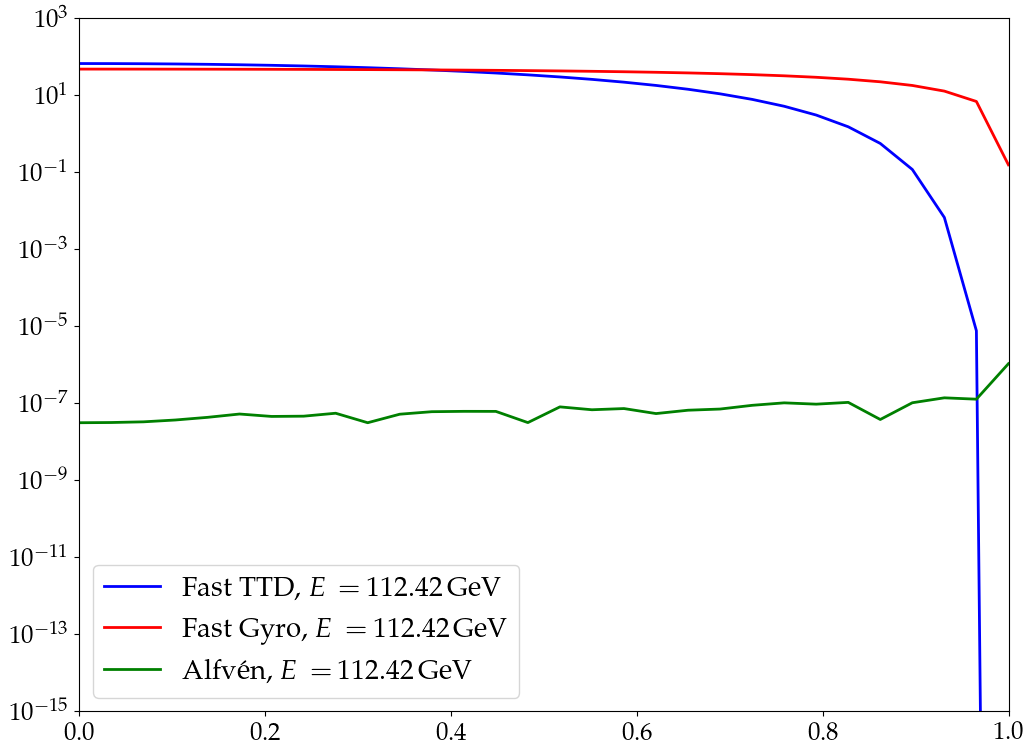

In [10]:
# This block shows the relative contributions of the three modes #

plt.figure(figsize=(12,9))

index_energy = 30   # 5, 30, 59 

plt.plot(mu, D_mumu_TTD_over_v[index_energy], lw=2, color='blue', label='Fast TTD, $E \, = \,$'+str( "{:.2f}".format(p_CR[index_energy]) )+'$\, \mathrm{GeV}$')
plt.plot(mu, D_mumu_Gyro_over_v[index_energy], lw=2, color='red', label='Fast Gyro, $E \, = \,$'+str( "{:.2f}".format(p_CR[index_energy]) )+'$\, \mathrm{GeV}$')
plt.plot(mu, D_mumu_Alfven_over_v_halo[index_energy], lw=2, color='green', label='Alfvén, $E \, = \,$'+str( "{:.2f}".format(p_CR[index_energy]) )+'$\, \mathrm{GeV}$')

plt.xlim(0., 1.)
plt.ylim(1.e-15, 1.e+3)
#plt.ylim(1.e-1, 1.e+2)
plt.yscale('log')

plt.legend(fontsize=20)

name_saved_pdf_D_mumu = 'D_mumu_Halo_Lhalo'+str(L_halo)+'_MA'+str(M_A_halo)+'_beta'+str(beta_halo)+'_Bfield'+str(B_field)+'_E'+str( "{:.2f}".format(p_CR[index_energy]) )+'.pdf'
plt.savefig(path_updated_plots + 'Scattering_efficiency_VarB/' + str(name_saved_pdf_D_mumu),format='pdf',bbox_inches='tight', dpi=200)


print(p_CR[index_energy])
print('')
print(p_CR)

I am fitting the curve between 1.5902872800870825e-07 and 1.6535781987657784e-06
29 39
Fit results: [103.40136413   0.27618567   1.        ]


/var/folders/7v/3qsg7nrd5fx6_1r1kwx67hlm0000gn/T/ipykernel_42715/3312900995.py:37: RuntimeWarning: overflow encountered in power
  return pow(10,28) * a * pow(x, b) + c
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


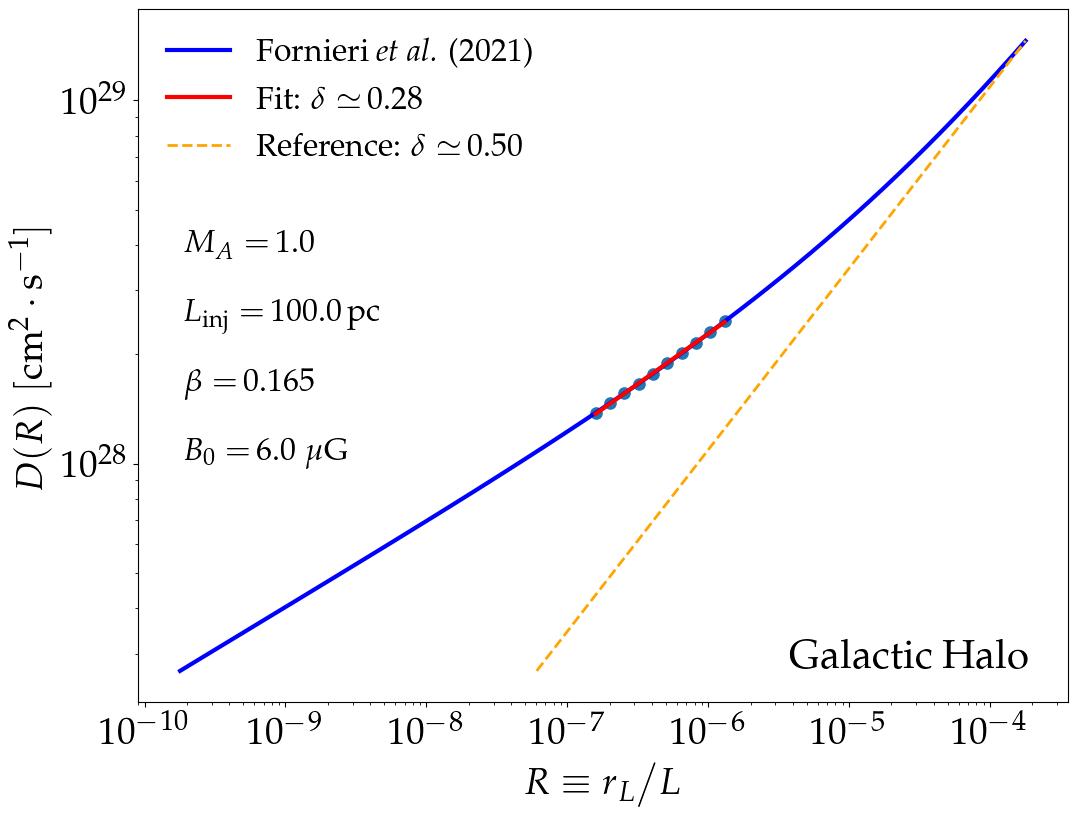

In [11]:
### Plotting block, to study ###


plt.figure(figsize=(12,9))


ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=27)
ax.tick_params(axis='both', which='minor', labelsize=27)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 5
ax.yaxis.labelpad = 7


f = mticker.ScalarFormatter(useMathText=True)
f.set_powerlimits((-5,5))


YL08_halo, = plt.plot(R_halo, integral_over_mu_Halo, lw=3., color='blue', label='Fornieri \\textit{et al.} (2021)')


## Fitting my curve in the requested range ##
R_halo_np = np.asarray(R_halo)

requested_energy_low = 100.  # in [GeV]
requested_energy_up = 1000.  # in [GeV]
index_requested_energy_low = np.argmin(abs(requested_energy_low - p_CR))
index_requested_energy_up = np.argmin(abs(requested_energy_up - p_CR))

print ("I am fitting the curve between", R_halo[index_requested_energy_low], "and", R_halo[index_requested_energy_up])
print (index_requested_energy_low, index_requested_energy_up)

fitting_index_range = np.arange(index_requested_energy_low, index_requested_energy_up)
fitting_points = integral_over_mu_Halo[fitting_index_range]

def fit_func(x, a, b, c):
    return pow(10,28) * a * pow(x, b) + c

popt, pcov = curve_fit(fit_func, R_halo_np[fitting_index_range], fitting_points)

print ("Fit results:", popt)

my_curve_halo, = plt.plot(R_halo_np[fitting_index_range], fit_func(R_halo_np[fitting_index_range], *popt),  color='red', lw=3., ls='-', label='Fit: $\delta \\simeq \,$'+ str("{:.2f}".format(popt[1])))
plt.scatter(R_halo_np[fitting_index_range], fitting_points, marker='o', s=65)
##############################################

## Draw the asymptote ##
slope_as = 0.5

x_max = max(R_halo)
y_max = max(integral_over_mu_Halo)
y_min = min(integral_over_mu_Halo)

x_0 = x_max / (y_max / y_min)**(1/slope_as)

x = np.linspace(start=x_0, stop=max(R_halo), num=100)

plt.loglog(x, y_min*(x / x_0)**slope_as, lw=2., ls='--', color='Orange', label='Reference: $\delta \\simeq \,$' + str("{:.2f}".format(slope_as)))
########################


plt.xlabel('$R \\equiv r_L \\big/ L$',fontsize=27)
plt.ylabel('$D(R) \; [\mathrm{cm}^{2} \cdot \mathrm{s}^{-1}]$',fontsize=27)
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1.e26, 1.e+29)


plt.legend(loc='best', frameon=False, fontsize=23)



plt.text(0.05, 0.65, r'$M_{A} = \,$'+str(M_A_halo),fontsize=23, transform = ax.transAxes)
plt.text(0.05, 0.55, r'$L_{\mathrm{inj}} = \,$'+str(L_halo)+'$\, \mathrm{pc}$',fontsize=23, transform = ax.transAxes)
plt.text(0.05, 0.45, r'$\beta = \,$'+str(beta_halo),fontsize=23, transform = ax.transAxes)
plt.text(0.05, 0.35, r'$B_0 = \,$'+str("${}$".format(B_field))+'$\; \mu \mathrm{G}$',fontsize=23, transform = ax.transAxes)
plt.text(0.7, 0.05, 'Galactic Halo',fontsize=29, transform = ax.transAxes)



name_saved_pdf = 'D_Halo_Lhalo'+str(L_halo)+'_MA'+str(M_A_halo)+'_beta'+str(beta_halo)+'_Bfield'+str(B_field)+'.pdf'
plt.savefig(path_updated_plots + 'Diffusion_coefficients_VarB/' + str(name_saved_pdf),format='pdf',bbox_inches='tight', dpi=200)


I am fitting the curve between 1.5902872800870825e-07 and 1.6535781987657784e-06
29 39
Fit results: [107.13466237   0.27858972   1.        ]


/var/folders/7v/3qsg7nrd5fx6_1r1kwx67hlm0000gn/T/ipykernel_42715/1835485898.py:74: RuntimeWarning: overflow encountered in power
  return pow(10,28) * a * pow(x, b) + c
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


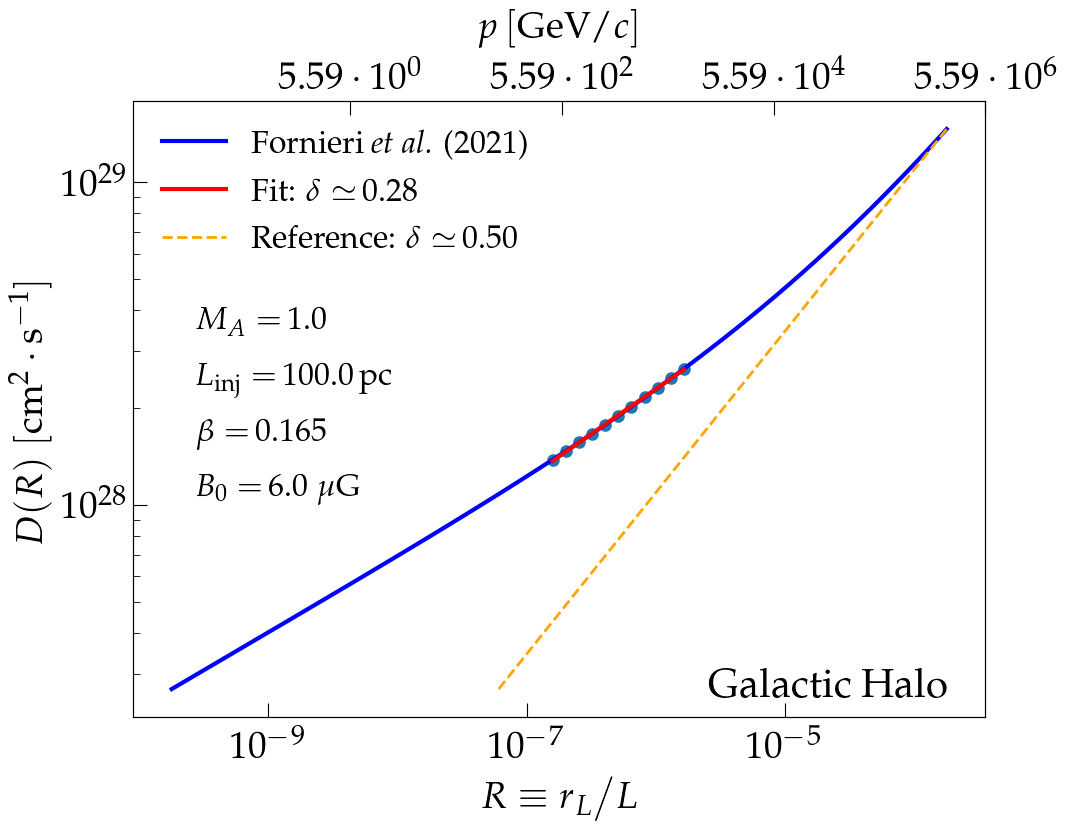

In [12]:
### Plot the secondary axis as well ###


from math import floor, log10
def sci_notation(num, decimal_digits=2, precision=None, exponent=None):
    
    if exponent is None:
        exponent = int(floor(log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits

    return "${0:.{2}f} \\cdot 10^{{{1:d}}}$".format(coeff, exponent, precision)



fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.tick_params(axis='both', which='major', labelsize=27, direction='in', length=10)
ax1.tick_params(axis='both', which='minor', labelsize=27, direction='in', length=5)
ax1.xaxis.set_tick_params(pad=10)
ax1.xaxis.labelpad = 5
ax1.yaxis.labelpad = 7


ax2.tick_params(axis='both', which='major', labelsize=27, direction='in', length=10)
ax2.tick_params(axis='both', which='minor', labelsize=27, direction='in', length=5)
ax2.xaxis.set_tick_params(pad=1)
ax2.xaxis.labelpad = 18


f = mticker.ScalarFormatter(useMathText=True)
f.set_powerlimits((-5,5))


ax1.loglog(R_halo, integral_over_mu_Halo, lw=3., color='blue', label='Fornieri \\textit{et al.} (2021)')
ax2.loglog(R_halo, integral_over_mu_Halo, lw=0., color='blue')
ax1.set_xlabel('$R \\equiv r_L \\big/ L$',fontsize=27)
ax1.set_ylabel('$D(R) \; [\mathrm{cm}^{2} \cdot \mathrm{s}^{-1}]$',fontsize=27)


new_tick_locations = np.array([1.e-8, 1.e-6, 1.e-4, 1.e-2])
def tick_function(R_):
    r_larmor = R_ * (L_halo*pc_cm)
    corresponding_energy = r_larmor / (3.31*1.e12) * B_field
    return corresponding_energy


ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
#ax2.set_xticklabels(["{:.2e}".format(tick_function(new_tick_locations[ir])) for ir in range(len(new_tick_locations))])
ax2.set_xticklabels([sci_notation(tick_function(new_tick_locations)[ir]) for ir in range(len(new_tick_locations))])
ax2.set_xlabel('$p \, [\mathrm{GeV}/c]$', fontsize=27)



## Fitting my curve in the requested range ##
R_halo_np = np.asarray(R_halo)

requested_energy_low = 100.  # in [GeV]
requested_energy_up = 1000.  # in [GeV]
index_requested_energy_low = np.argmin(abs(requested_energy_low - p_CR))
index_requested_energy_up = np.argmin(abs(requested_energy_up - p_CR))

print ("I am fitting the curve between", R_halo[index_requested_energy_low], "and", R_halo[index_requested_energy_up])
print (index_requested_energy_low, index_requested_energy_up)

fitting_index_range = np.arange(index_requested_energy_low, index_requested_energy_up+1)
fitting_points = integral_over_mu_Halo[fitting_index_range]

def fit_func(x, a, b, c):
    return pow(10,28) * a * pow(x, b) + c

popt, pcov = curve_fit(fit_func, R_halo_np[fitting_index_range], fitting_points)
print ("Fit results:", popt)

ax1.loglog(R_halo_np[fitting_index_range], fit_func(R_halo_np[fitting_index_range], *popt),  color='red', lw=3., ls='-', label='Fit: $\delta \\simeq \,$'+ str("{:.2f}".format(popt[1])))
ax1.scatter(R_halo_np[fitting_index_range], fitting_points, marker='o', s=65)
##############################################

## Draw the asymptote ##
slope_as = 0.5

x_max = max(R_halo)
y_max = max(integral_over_mu_Halo)
y_min = min(integral_over_mu_Halo)
x_0 = x_max / (y_max / y_min)**(1/slope_as)

x = np.linspace(start=x_0, stop=max(R_halo), num=100)

ax1.loglog(x, y_min*(x / x_0)**slope_as, lw=2., ls='--', color='Orange', label='Reference: $\delta \\simeq \,$' + str("{:.2f}".format(slope_as)))
########################


ax1.legend(loc='best', frameon=False, fontsize=23)

ax1.text(0.05, 0.58, r'$M_{A} = \,$'+str(M_A_halo),fontsize=23, transform = ax.transAxes)
ax1.text(0.05, 0.5, r'$L_{\mathrm{inj}} = \,$'+str(L_halo)+'$\, \mathrm{pc}$',fontsize=23, transform = ax.transAxes)
ax1.text(0.05, 0.42, r'$\beta = \,$'+str(beta_halo),fontsize=23, transform = ax.transAxes)
ax1.text(0.05, 0.34, r'$B_0 = \,$'+str("${}$".format(B_field))+'$\; \mu \mathrm{G}$',fontsize=23, transform = ax.transAxes)
ax1.text(0.6, 0.05, 'Galactic Halo',fontsize=29, transform = ax.transAxes)


name_saved_pdf = '2Axes_D_Halo_Lhalo'+str(L_halo)+'_MA'+str(M_A_halo)+'_beta'+str(beta_halo)+'_Bfield'+str(B_field)+'.pdf'
plt.savefig(path_updated_plots + 'Diffusion_coefficients_VarB/' + str(name_saved_pdf),format='pdf',bbox_inches='tight', dpi=200)

In [13]:
### Block to store the output D(R) in a text file ###

print (len(p_CR), len(R_halo_np), len(integral_over_mu_Halo))

data_for_text_file = np.zeros( (len(p_CR), 3) )

data_for_text_file[:,0] = p_CR
data_for_text_file[:,1] = R_halo_np
data_for_text_file[:,2] = integral_over_mu_Halo

print (data_for_text_file)

txt_file_name = 'D_Halo_Lhalo'+str(L_halo)+'_MA'+str(M_A_halo)+'_beta'+str(beta_halo)+'_Bfield'+str(B_field)+'.txt'
np.savetxt(path_updated_plots + 'Text_files_coefficients_VarB/' + txt_file_name, data_for_text_file)

60 60 60
[[1.00000000e-01 1.78781692e-10 2.68719465e+27]
 [1.26384820e-01 2.25952920e-10 2.83940043e+27]
 [1.59731228e-01 2.85570192e-10 3.00005681e+27]
 [2.01876025e-01 3.60917374e-10 3.16985023e+27]
 [2.55140652e-01 4.56144774e-10 3.34925803e+27]
 [3.22459055e-01 5.76497753e-10 3.53873917e+27]
 [4.07539297e-01 7.28605650e-10 3.73893355e+27]
 [5.15067808e-01 9.20846941e-10 3.95040315e+27]
 [6.50967523e-01 1.16381075e-09 4.17376096e+27]
 [8.22724134e-01 1.47088013e-09 4.41011342e+27]
 [1.03979842e+00 1.85896920e-09 4.66026462e+27]
 [1.31414736e+00 2.34945489e-09 4.92481051e+27]
 [1.66088278e+00 2.96935434e-09 5.20474376e+27]
 [2.09910372e+00 3.75281315e-09 5.50110105e+27]
 [2.65294846e+00 4.74298615e-09 5.81488234e+27]
 [3.35292415e+00 5.99441452e-09 6.14758617e+27]
 [4.23758716e+00 7.57603002e-09 6.50049195e+27]
 [5.35566692e+00 9.57495193e-09 6.87486897e+27]
 [6.76875001e+00 1.21012858e-08 7.27225616e+27]
 [8.55467254e+00 1.52941883e-08 7.69439499e+27]
 [1.08118075e+01 1.93295324e-08

[[1.00000000e-001 1.78781692e-010             inf]
 [1.26384820e-001 2.25952920e-010             inf]
 [1.59731228e-001 2.85570192e-010             inf]
 [2.01876025e-001 3.60917374e-010             inf]
 [2.55140652e-001 4.56144774e-010             inf]
 [3.22459055e-001 5.76497753e-010             inf]
 [4.07539297e-001 7.28605650e-010             inf]
 [5.15067808e-001 9.20846941e-010             inf]
 [6.50967523e-001 1.16381075e-009             inf]
 [8.22724134e-001 1.47088013e-009             inf]
 [1.03979842e+000 1.85896920e-009             inf]
 [1.31414736e+000 2.34945489e-009             inf]
 [1.66088278e+000 2.96935434e-009             inf]
 [2.09910372e+000 3.75281315e-009             inf]
 [2.65294846e+000 4.74298615e-009             inf]
 [3.35292415e+000 5.99441452e-009 7.25103137e+158]
 [4.23758716e+000 7.57603002e-009 2.87310846e+065]
 [5.35566692e+000 9.57495193e-009 2.72602953e+039]
 [6.76875001e+000 1.21012858e-008 1.90608192e+039]
 [8.55467254e+000 1.52941883e-0

/var/folders/7v/3qsg7nrd5fx6_1r1kwx67hlm0000gn/T/ipykernel_42715/3556000327.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  integrand_mu_Halo_Alf[ir][im] = 1/4 * ( c**2 / (D_mumu_Alfven_over_v_halo[ir][im]*c/(L_halo*pc_cm)) ) * pow( 1 - mu[im]**2 , 2 )
/var/folders/7v/3qsg7nrd5fx6_1r1kwx67hlm0000gn/T/ipykernel_42715/3556000327.py:11: RuntimeWarning: overflow encountered in double_scalars
  integrand_mu_Halo_Alf[ir][im] = 1/4 * ( c**2 / (D_mumu_Alfven_over_v_halo[ir][im]*c/(L_halo*pc_cm)) ) * pow( 1 - mu[im]**2 , 2 )
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


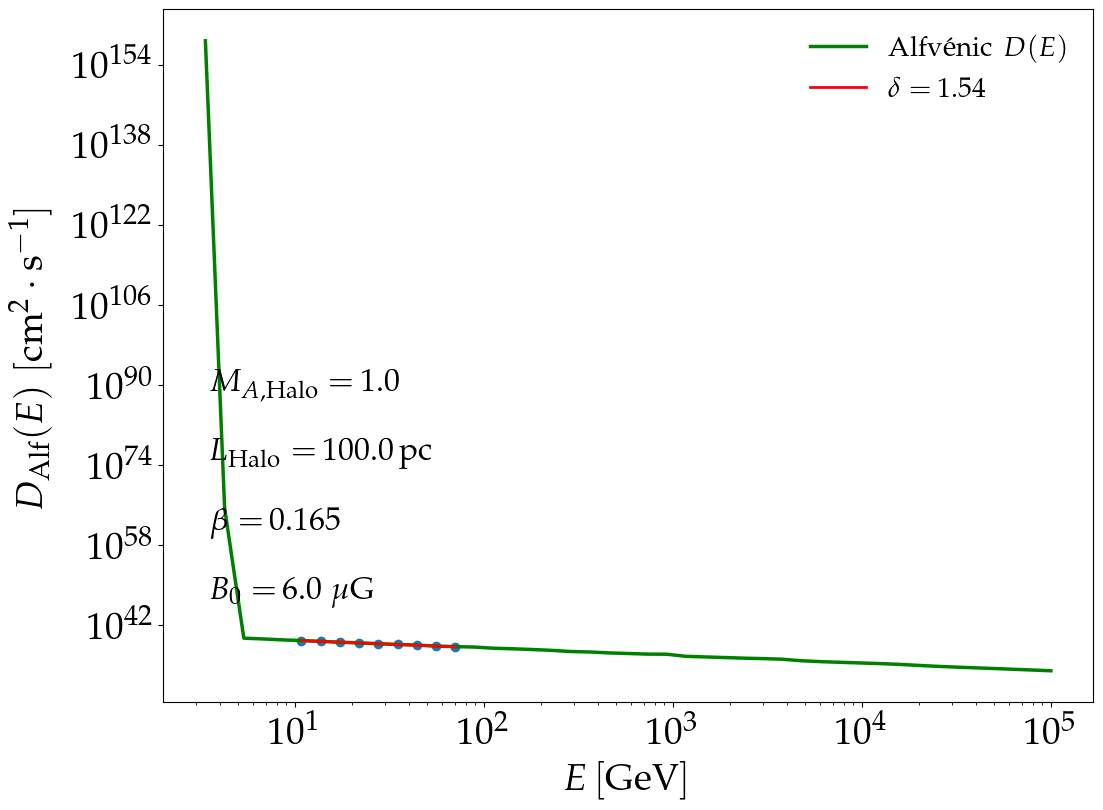

In [14]:
### Block to store and plot the Alfvénic contribution only ###

integrand_mu_Halo_Alf = np.zeros( (len(R_halo),len(mu)) )
integral_over_mu_Halo_Alf = np.zeros( len(R_halo) )



for ir in range(len(R_halo)):
    
    for im in range(len(mu)):
        integrand_mu_Halo_Alf[ir][im] = 1/4 * ( c**2 / (D_mumu_Alfven_over_v_halo[ir][im]*c/(L_halo*pc_cm)) ) * pow( 1 - mu[im]**2 , 2 )
    
    integral_over_mu_Halo_Alf[ir] = integrate.trapz(integrand_mu_Halo_Alf[ir], mu)
    
    
    
data_for_text_file_Alf = np.zeros( (len(p_CR), 3) )

data_for_text_file_Alf[:,0] = p_CR
data_for_text_file_Alf[:,1] = R_halo_np
data_for_text_file_Alf[:,2] = integral_over_mu_Halo_Alf

print(data_for_text_file_Alf)



plt.figure(figsize=(12,9))

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=27)
ax.tick_params(axis='both', which='minor', labelsize=27)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 5
ax.yaxis.labelpad = 15

f = mticker.ScalarFormatter(useMathText=True)
f.set_powerlimits((-5,5))
    
    
chosen_energy = 1.e+0
chosen_energy_Kol = 2.e+3
chosen_index = np.argmin(abs(chosen_energy - p_CR))
chosen_index_Kol = np.argmin(abs(chosen_energy_Kol - p_CR))

plt.loglog(p_CR[chosen_index:], integral_over_mu_Halo_Alf[chosen_index:], lw=2.5, color='green', label='Alfvénic $\, D(E)$')


## Fitting my curve in the requested range ##
requested_energy_low = 10.  # in [GeV]
requested_energy_up = 100.  # in [GeV]
index_requested_energy_low = np.argmin(abs(requested_energy_low - p_CR))
index_requested_energy_up = np.argmin(abs(requested_energy_up - p_CR))

print ("I am fitting the curve between", p_CR[index_requested_energy_low], "and", p_CR[index_requested_energy_up])
print (index_requested_energy_low, index_requested_energy_up)

fitting_index_range = np.arange(index_requested_energy_low, index_requested_energy_up)
fitting_points = integral_over_mu_Halo_Alf[fitting_index_range]

def fit_func(x, a, b, c):
    return pow(10,33) * a * pow(x, -b) + c

popt, pcov = curve_fit(fit_func, p_CR[fitting_index_range], fitting_points)

print ("Fit results:", popt)

my_curve_halo, = plt.plot(p_CR[fitting_index_range], fit_func(p_CR[fitting_index_range], *popt),  color='red', lw=2, ls='-', label='$\delta = \,$' + str("{:.2f}".format(popt[1])))
plt.scatter(p_CR[fitting_index_range], fitting_points, marker='o')
##############################################


plt.xlabel('$E \, [\mathrm{GeV}]$',fontsize=27)
plt.ylabel('$D_{\mathrm{Alf}}(E) \; [\mathrm{cm}^{2} \cdot \mathrm{s}^{-1}]$',fontsize=27)
plt.legend(loc='best', frameon=False, fontsize=20)


plt.text(0.05, 0.45, r'$M_{A, \mathrm{Halo}} = \,$'+str(M_A_halo),fontsize=23, transform = ax.transAxes)
plt.text(0.05, 0.35, r'$L_{\mathrm{Halo}} = \,$'+str(L_halo)+'$\, \mathrm{pc}$',fontsize=23, transform = ax.transAxes)
plt.text(0.05, 0.25, r'$\beta = \,$'+str(beta_halo),fontsize=23, transform = ax.transAxes)
plt.text(0.05, 0.15, r'$B_0 = \,$'+str("${}$".format(B_field))+'$\; \mu \mathrm{G}$',fontsize=23, transform = ax.transAxes)



name_saved_pdf_Alf = 'D_Alf_Halo_Lhalo'+str(L_halo)+'_MA'+str(M_A_halo)+'_beta'+str(beta_halo)+'_Bfield'+str(B_field)+'.pdf'
plt.savefig(path_updated_plots + 'Diffusion_coefficients_VarB/' + str(name_saved_pdf_Alf),format='pdf',bbox_inches='tight', dpi=200)


txt_file_name_Alf = 'D_Alf_Halo_Lhalo'+str(L_halo)+'_MA'+str(M_A_halo)+'_beta'+str(beta_halo)+'_Bfield'+str(B_field)+'.txt'
np.savetxt(path_updated_plots + 'Text_files_coefficients_VarB/' + txt_file_name_Alf, data_for_text_file_Alf)
